In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

import os
import json

In [14]:
def get_info_from_dirname(dirname):
    
    info = dirname.split("_")
    algorithm = info[2]+"_"+info[3]
    matname = info[4]
    nodes = int(info[5].split("Nodes")[0])
    
    return algorithm, matname, nodes

In [15]:
path = "./timings"
os.listdir(path)

['timings_run_combblas_2d_celegans_4Nodes',
 'timings_run_spsyrk_1d_celegans_1Nodes',
 'timings_run_spsyrk_1d_celegans_16Nodes',
 'timings_run_spsyrk_1d_celegans_4Nodes',
 'timings_run_spsyrk_2d_celegans_1Nodes',
 'timings_run_combblas_2d_celegans_16Nodes',
 'timings_run_combblas_2d_celegans_1Nodes']

In [16]:
dirs = os.listdir(path)
syrk_1d_df = pd.DataFrame()
syrk_2d_df = pd.DataFrame()
combblas_df = pd.DataFrame()
for d in dirs:
    
    experiment_info = get_info_from_dirname(d)    
    csv_files = list(filter(lambda s: ".csv" in s, os.listdir(f"{path}/{d}")))
    
    # This sucks
    for f in csv_files:
        timing_df = pd.read_csv(f"{path}/{d}/{f}")
        if "combblas" in experiment_info[0]:
            timing_df = timing_df.loc[timing_df["Timer Name"]=="CPUMult"]
        colnames = list(timing_df.iloc[:, 0])
        timing_df = timing_df.transpose()
        timing_df.columns = colnames
        timing_df["Algorithm"], timing_df["Matrix"], timing_df["nodes"] = experiment_info
        timing_df["rank"] = f.split("_")[-1].split(".csv")[0]
        timing_df = timing_df.iloc[[1]]
        if "spsyrk_1d" in experiment_info[0]:
            syrk_1d_df = pd.concat([syrk_1d_df, timing_df], ignore_index=True)
        elif "spsyrk_2d" in experiment_info[0]:
            syrk_2d_df = pd.concat([syrk_2d_df, timing_df], ignore_index=True)
        elif "combblas" in experiment_info[0]:
            combblas_df = pd.concat([combblas_df, timing_df], ignore_index=True)

In [38]:
def plot_runtimes(syrk_2d_df, syrk_1d_df, combblas_df):
    
    syrk_2d_f = list(syrk_2d_df.groupby("nodes")["SpSYRK"])
    syrk_1d_f = list(syrk_1d_df.groupby("nodes")["SpSYRK"])
    combblas_f = list(combblas_df.groupby("nodes")["CPUMult"])
    
    nodes = []
    syrk_2d_y = []
    for i in range(len(syrk_2d_f)):
        syrk_2d_y.append(list(syrk_2d_f[i][1])[0]) # This is horrible
    
    syrk_1d_y = []
    for i in range(len(syrk_1d_f)):
        syrk_1d_y.append(list(syrk_1d_f[i][1])[0]) # This is horrible
        nodes.append(list(list(syrk_1d_df.groupby("nodes")["nodes"])[i][1])[0])
    
    combblas_y = []
    for i in range(len(combblas_f)):
        combblas_y.append(list(combblas_f[i][1])[0]) # This is horrible
    
    for i in range(len(syrk_1d_y)-len(syrk_2d_y)):
        syrk_2d_y.append(0)
    ind = np.arange(len(syrk_1d_y))
    
    wid=0.2
    plt.bar(ind-wid, combblas_y, width=wid, edgecolor='black', label="CombBLAS")
    plt.bar(ind, syrk_1d_y, width=wid, edgecolor='black', label="SpSYRK1D") 
    plt.bar(ind+wid, syrk_2d_y, width=wid, edgecolor='black', label="SpSYRK2D") 
    plt.xticks(ind, np.array(nodes)*4)
    plt.ylabel("Runtime (s)")
    plt.xlabel("GPUs")
    plt.title(f"Runtime Comparison for {syrk_2d_df['Matrix'][0]}")
    plt.legend()
    plt.savefig(f"./plots/runtimes_{syrk_2d_df['Matrix'][0]}", bbox_inches='tight')

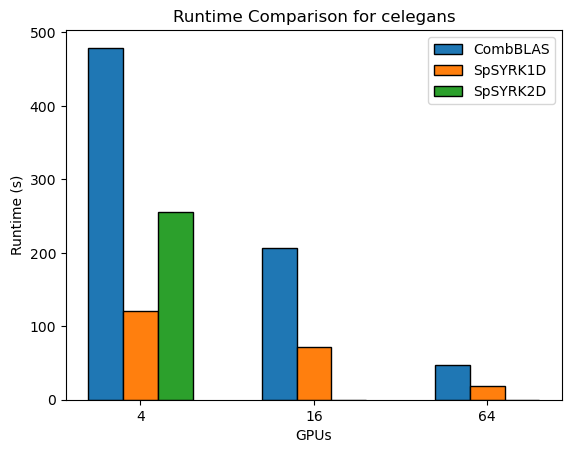

In [39]:
plot_runtimes(syrk_2d_df, syrk_1d_df, combblas_df)

In [19]:
def plot_breakdown_2d(df):
    plt.figure(figsize=(10, 6))
    gpn = 4

    # Bar positions
    ind = range(len(df))

    # Bottom bars (for stacking)
    bar1 = df['Merge']
    bar2 = df['Merge'] + df['TuplesMemcpy']
    bar3 = df['Merge'] + df['TuplesMemcpy'] + df['LocalMultiply']

    # Plotting each group, stacking the bars
    plt.bar(ind, df['Merge'], label='Merge', edgecolor='black')
    plt.bar(ind, df['TuplesMemcpy'], bottom=df['Merge'], label='CopyTriples', edgecolor='black')
    plt.bar(ind, df['LocalMultiply'], bottom=bar2, label='LocalMultiply', edgecolor='black')
    plt.bar(ind, df['TileGet'], bottom=bar3, label='TileGet', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Rank')
    plt.ylabel('Runtime (s)')
    plt.title(f'Runtime Breakdown of 2D SpSYRK on {list(df["Matrix"])[0]} ({gpn*(list(df["nodes"])[0])} GPUs)')

    # Set the ticks on x-axis
    plt.xticks(ind, df["rank"])

    # Adding the legend
    plt.legend(loc='upper right')
    
    plt.savefig(f"./plots/breakdown_2d_{list(df['Matrix'])[0]}", bbox_inches='tight')

    # Display the plot
    plt.show()

In [20]:
def plot_breakdown_2d_nomerge(df):
    plt.figure(figsize=(10, 6))
    gpn = 4

    # Bar positions
    ind = range(len(df))

    # Bottom bars (for stacking)
    bar1 = df['TuplesMemcpy']
    bar2 = df['TuplesMemcpy'] + df['LocalMultiply']

    # Plotting each group, stacking the bars
    plt.bar(ind, df['TuplesMemcpy'], label='CopyTriples', edgecolor='black')
    plt.bar(ind, df['LocalMultiply'], bottom=bar1, label='LocalMultiply', edgecolor='black')
    plt.bar(ind, df['TileGet'], bottom=bar2, label='TileGet', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Rank')
    plt.ylabel('Runtime (s)')
    plt.title(f'Runtime Breakdown of 2D SpSYRK on {list(df["Matrix"])[0]} ({gpn*(list(df["nodes"])[0])} GPUs)')

    # Set the ticks on x-axis
    plt.xticks(ind, df["rank"])

    # Adding the legend
    plt.legend(loc='upper right')
    
    plt.savefig(f"./plots/breakdown_2d_nomerge_{list(df['Matrix'])[0]}", bbox_inches='tight')

    # Display the plot
    plt.show()

In [40]:
def plot_breakdown_1d(df):
    plt.figure(figsize=(10, 6))
    gpn = 4

    # Bar positions
    ind = np.arange(len(df))

    # Bottom bars (for stacking)
    bar1 = df['Merge']
    bar2 = df['Merge'] + df['CopyTriples']
    bar3 = df['Merge'] + df['CopyTriples'] + df['LocalMultiply']

    # Plotting each group, stacking the bars
    plt.bar(ind, df['Merge'], label='Merge', edgecolor='black')
    plt.bar(ind, df['CopyTriples'], bottom=df['Merge'], label='CopyTriples', edgecolor='black')
    plt.bar(ind, df['LocalMultiply'], bottom=bar2, label='LocalMultiply', edgecolor='black')
    plt.bar(ind, df['Broadcast'], bottom=bar3, label='Broadcast', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Rank')
    plt.ylabel('Runtime (s)')
    plt.title(f'Runtime Breakdown of 1D SpSYRK on {list(df["Matrix"])[0]} ({gpn*(list(df["nodes"])[0])} GPUs)')

    # Set the ticks on x-axis
    plt.xticks(ind[::16], df["rank"][::16])

    # Adding the legend
    plt.legend(loc='upper right')
    
    plt.savefig(f"./plots/breakdown_1d_{list(df['Matrix'])[0]}", bbox_inches='tight')

    # Display the plot
    plt.show()

In [41]:
def plot_breakdown_1d_nomerge(df):
    plt.figure(figsize=(10, 6))
    gpn = 4

    # Bar positions
    ind = range(len(df))

    # Bottom bars (for stacking)
    bar1 = df['CopyTriples']
    bar2 = df['CopyTriples'] + df['LocalMultiply']

    # Plotting each group, stacking the bars
    #plt.bar(ind, df['Merge'], label='Merge', edgecolor='black')
    plt.bar(ind, df['CopyTriples'], label='CopyTriples', edgecolor='black')
    plt.bar(ind, df['LocalMultiply'], bottom=bar1, label='LocalMultiply', edgecolor='black')
    plt.bar(ind, df['Broadcast'], bottom=bar2, label='Broadcast', edgecolor='black')

    # Adding labels and title
    plt.xlabel('Rank')
    plt.ylabel('Runtime (s)')
    plt.title(f'Runtime Breakdown of 1D SpSYRK on {list(df["Matrix"])[0]} ({gpn*(list(df["nodes"])[0])} GPUs)')

    # Set the ticks on x-axis
    plt.xticks(ind[::16], df["rank"][::16])

    # Adding the legend
    plt.legend(loc='upper right')
    
    plt.savefig(f"./plots/breakdown_1d_nomerge_{list(df['Matrix'])[0]}", bbox_inches='tight')

    # Display the plot
    plt.show()

/tmp/ipykernel_539636/3934072531.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  syrk_1d_bdown_df['rank'] = pd.to_numeric(syrk_1d_bdown_df['rank'], errors='coerce')


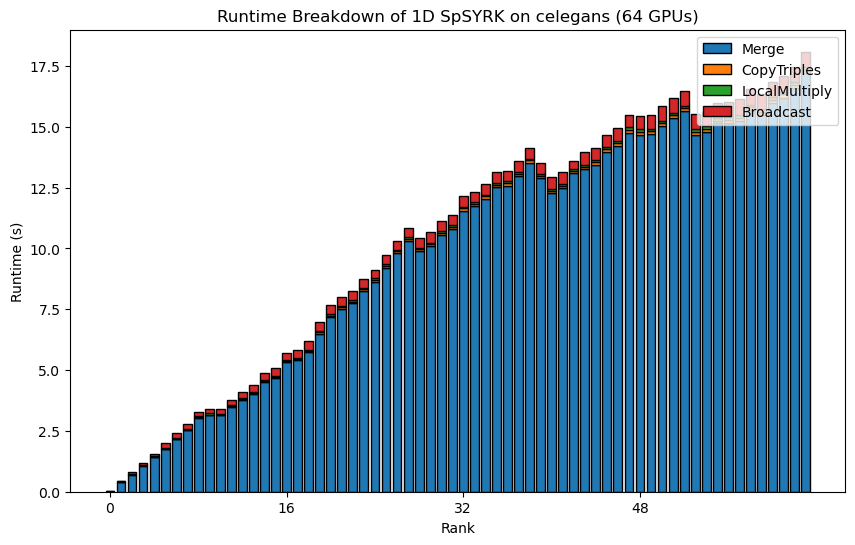

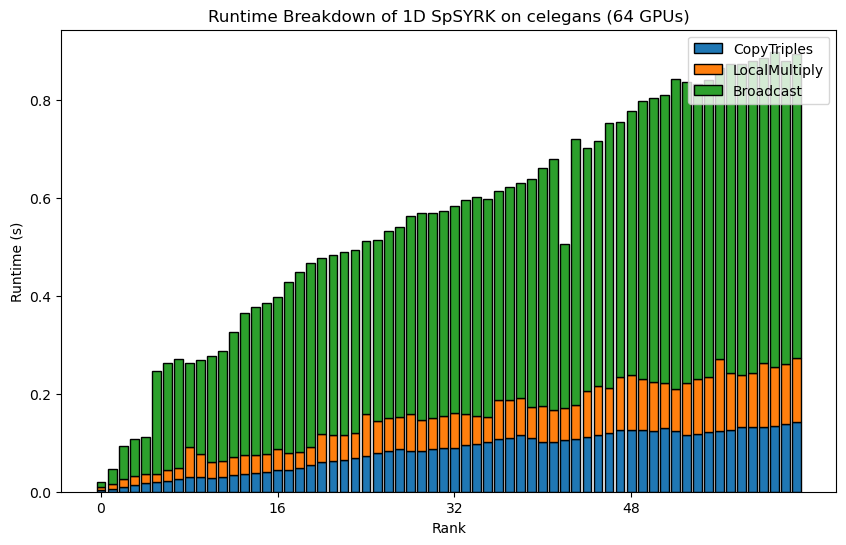

In [42]:
syrk_1d_bdown_df = syrk_1d_df.loc[syrk_1d_df["nodes"]==16]
syrk_1d_bdown_df['rank'] = pd.to_numeric(syrk_1d_bdown_df['rank'], errors='coerce')
syrk_1d_bdown_df = syrk_1d_bdown_df.sort_values(by='rank')
plot_breakdown_1d(syrk_1d_bdown_df)
plot_breakdown_1d_nomerge(syrk_1d_bdown_df)

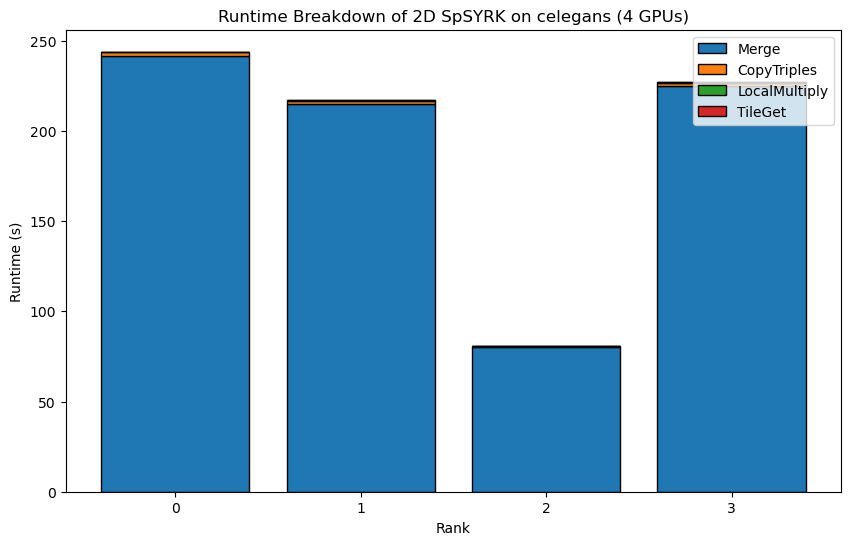

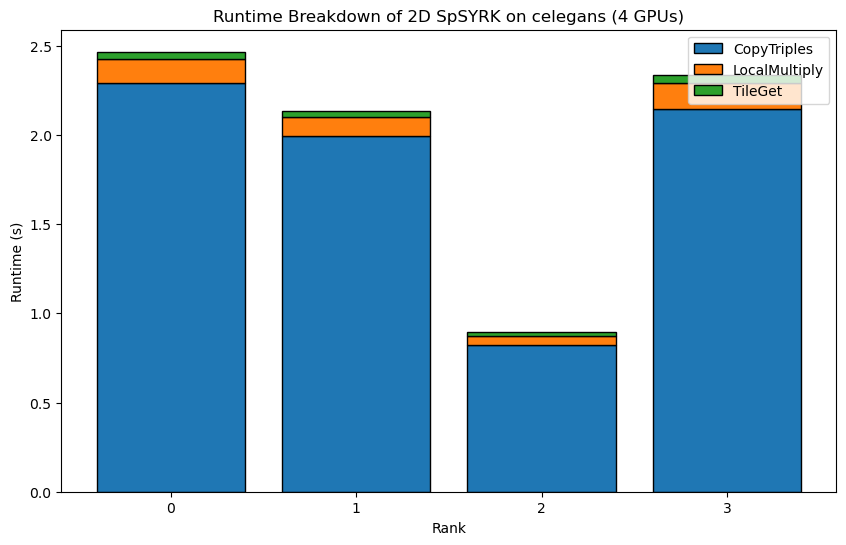

In [227]:
syrk_2d_df['rank'] = pd.to_numeric(syrk_2d_df['rank'])
syrk_2d_bdown_df = syrk_2d_df.sort_values(by='rank')
plot_breakdown_2d(syrk_2d_bdown_df)
plot_breakdown_2d_nomerge(syrk_2d_bdown_df)